### **Búsqueda y Minería de Información 2021-22**
### Universidad Autónoma de Madrid, Escuela Politécnica Superior
### Grado en Ingeniería Informática, 4º curso
# **Implementación de un motor de búsqueda**

Fechas:

* Comienzo: lunes 7 / martes 8 de febrero
* Entrega: lunes 21 / martes 22 de febrero (14:00)

# Introducción

## Objetivos

Los objetivos de esta práctica son:

* La iniciación a la implementación de un motor de búsqueda.
*	Una primera comprensión de los elementos básicos necesarios para implementar un motor completo.
*	La iniciación al uso de la librería [Whoosh](https://whoosh.readthedocs.io/en/latest/intro.html) en Python para la creación y utilización de índices, funcionalidades de búsqueda en texto.
*	La iniciación a la implementación de una función de ránking sencilla.

Los documentos que se indexarán en esta práctica, y sobre los que se realizarán consultas de búsqueda serán documentos HTML, que deberán ser tratados para extraer y procesar el texto contenido en ellos. 

La práctica plantea como punto de partida una pequeña API general sencilla, que pueda implementarse de diferentes maneras, como así se hará en esta práctica y las siguientes. A modo de toma de contacto y arranque de la asignatura, en esta primera práctica se completará una implementación de la API utilizando Whoosh, con lo que resultará bastante trivial la solución (en cuanto a la cantidad de código a escribir). En la siguiente práctica el estudiante desarrollará sus propias implementaciones, sustituyendo el uso de Whoosh que vamos a hacer en esta primera práctica.

En términos de operaciones propias de un motor de búsqueda, en esta práctica el estudiante se encargará fundamentalmente de:

a) En el proceso de indexación: recorrer los documentos de texto de una colección dada, eliminar del contenido posibles marcas tales como html, y enviar el texto a indexar por parte de Whoosh. 

b) En el proceso de responder consultas: implementar una primera versión sencilla de una o dos funciones de ránking en el modelo vectorial, junto con alguna pequeña estructura auxiliar.

## Material proporcionado

Se proporcionan (bien en el curso de Moodle o dentro de este documento):

*	Varias clases e interfaces Python a lo largo de este *notebook*, desde las que el estudiante partirá para completar código e integrará las suyas propias. 
En particular, la función **main** implementa un programa que deberá funcionar con el código a implementar por el estudiante. Además, se proporciona una celda con código que muestra las funciones más útiles de la API de Whoosh.
*	Una pequeña colección <ins>docs1k.zip</ins> con aproximadamente 1.000 documentos HTML, y un pequeño fichero <ins>urls.txt</ins>. Ambas representan colecciones de prueba para depurar las implementaciones y comprobar su corrección.
*	Un documento de texto <ins>output.txt</ins> con la salida estándar que deberá producir la ejecución de la función main.

In [1]:
import math
from abc import ABC, abstractmethod


"""
    This is an abstract class for the search engines
"""
class Searcher(ABC):
    def __init__(self, index):
        self.index = index
    @abstractmethod
    def search(self, query, cutoff):
        """ Returns a list of documents built as a pair of path and score """

In [2]:
# Whoosh API
import whoosh
from whoosh.fields import Schema, TEXT, ID
from whoosh.formats import Format
from whoosh.qparser import QueryParser
from urllib.request import urlopen
from bs4 import BeautifulSoup
import os, os.path
import shutil

Document = Schema(
        path=ID(stored=True),
        content=TEXT(vector=Format))

def whooshexample_buildindex(dir, urls):
    if os.path.exists(dir): shutil.rmtree(dir)
    os.makedirs(dir)
    writer = whoosh.index.create_in(dir, Document).writer()
    for url in urls:
        writer.add_document(path=url, content=BeautifulSoup(urlopen(url).read(), "lxml").text)
    writer.commit()

def whooshexample_search(dir, query):
    index = whoosh.index.open_dir(dir)
    searcher = index.searcher()
    qparser = QueryParser("content", schema=index.schema)
    print("Search results for '", query, "'")
    for docid, score in searcher.search(qparser.parse(query)).items():
        print(score, "\t", index.reader().stored_fields(docid)['path'])
    print()

def whooshexample_examine(dir, term, docid, n):
    reader = whoosh.index.open_dir(dir).reader()
    print("Total nº of documents in the collection:", reader.doc_count())
    print("Total frequency of '", term, "':", reader.frequency("content", term))
    print("Nº documents containing '", term, "':", reader.doc_frequency("content", term))
    for p in reader.postings("content", term).items_as("frequency") if reader.doc_frequency("content", term) > 0 else []:
        print("\tFrequency of '", term, "' in document", p[0], ":", p[1])
    raw_vec = reader.vector(docid, "content")
    raw_vec.skip_to(term)
    if raw_vec.id() == term:
        print("Frequency of '", raw_vec.id(), "' in document", docid, reader.stored_fields(docid)['path'], ":", raw_vec.value_as("frequency"))
    else:
        print("Term '", term, "' not found in document", docid)
    print("Top", n, "most frequent terms in document", docid, reader.stored_fields(docid)['path']) 
    vec = reader.vector(docid, "content").items_as("frequency")
    for p in sorted(vec, key=lambda x: x[1], reverse=True)[0:n]:
        print("\t", p)
    print()

urls = ["https://en.wikipedia.org/wiki/Simpson's_paradox", 
        "https://en.wikipedia.org/wiki/Bias",
        "https://en.wikipedia.org/wiki/Entropy"]

dir = "index/whoosh/example/urls"

whooshexample_buildindex(dir, urls)
whooshexample_search(dir, "probability")
whooshexample_examine(dir, "probability", 0, 5)

Search results for ' probability '
1.481735543350193 	 https://en.wikipedia.org/wiki/Simpson's_paradox
1.4190366965408714 	 https://en.wikipedia.org/wiki/Entropy
0.6458676648795822 	 https://en.wikipedia.org/wiki/Bias

Total nº of documents in the collection: 3
Total frequency of ' probability ': 27.0
Nº documents containing ' probability ': 3
	Frequency of ' probability ' in document 0 : 10
	Frequency of ' probability ' in document 1 : 1
	Frequency of ' probability ' in document 2 : 16
Frequency of ' probability ' in document 0 https://en.wikipedia.org/wiki/Simpson's_paradox : 10
Top 5 most frequent terms in document 0 https://en.wikipedia.org/wiki/Simpson's_paradox
	 ('paradox', 50)
	 ('simpson', 48)
	 ('data', 17)
	 ('treatment', 17)
	 ('two', 15)



## Calificación

Esta práctica se calificará con una puntuación de 0 a 10 atendiendo a las puntuaciones individuales de ejercicios y apartados dadas en el enunciado.  

El peso de la nota de esta práctica en la calificación final de prácticas es del **20%**.

La calificación se basará en a) el **número** de ejercicios realizados y b) la **calidad** de los mismos. 
La puntuación que se indica en cada apartado es orientativa, en principio se aplicará tal cual se refleja pero podrá matizarse por criterios de buen sentido si se da el caso.

Para dar por válida la realización de un ejercicio, el código deberá funcionar (a la primera) integrado con las clases que se facilitan, **sin ninguna modificación**. El profesor comprobará este aspecto añadiendo los módulos entregados por el estudiante a los módulos facilitados en la práctica, ejecutando la función main así como otros main de prueba adicionales.

## Entrega

La entrega consistirá en un único fichero tipo *notebook* donde se incluirán todas las **implementaciones** solicitadas en cada ejercicio, así como una explicación de cada uno a modo de **memoria**.

En concreto, se debe documentar:

- Qué version(es) del modelo vectorial se ha(n) implementado en el ejercicio 2.
- Cómo se ha conseguido colocar un documento en la primera posición de ránking, para cada buscador implementado en el ejercicio 2.
- El trabajo realizado en el ejercicio 3. 
- Y cualquier otro aspecto que el estudiante considere oportuno destacar.


## Indicaciones

Se podrán definir clases adicionales a las que se indican en el enunciado, por ejemplo, para reutilizar código. Y el estudiante podrá utilizar o no el software que se le proporciona, con la siguiente limitación: 

*	No deberá editarse el software proporcionado más allá de donde se indica explícitamente.
*	El programa **main deberá ejecutar** correctamente.

# Ejercicio 1: Implementación basada en Whoosh

Implementar las clases y módulos necesarios para que el programa main funcione. Se deja al estudiante deducir alguna de las relaciones jerárquicas entre las clases Python.

## Ejercicio 1.1: Indexación (3pt)

Definir las siguientes clases:

* Index.
* WhooshIndex, como subclase de Index.
*	WhooshBuilder, como subclase de Builder.

Se sugiere utilizar dos “fields” en el esquema de documentos de Whoosh: la ruta del documento (dirección Web o ruta en disco), y el contenido del documento.

La entrada para construir el índice (método Builder.build()) podrá ser a) un fichero de texto con direcciones Web (una por línea); b) una carpeta del disco (se indexarán todos los ficheros de la carpeta, sin entrar en subcarpetas); o c) un archivo zip que contiene archivos comprimidos a indexar. Supondremos que el contenido a indexar es siempre HTML.

In [3]:
class Index:
    def __init__(self, path):
        pass

    def doc_vector(self, doc_id):
        pass

    def ndocs(self):
        pass

    def all_terms(self):
        pass

    def all_terms_with_freq(self):
        pass

    def total_freq(self, term):
        pass

    def doc_path(self, id):
        pass

    def term_freq(self, term, id):
        pass

    def doc_freq(self, term):
        pass

    def postings(self, term):
        pass

In [4]:
import whoosh
from whoosh.fields import Schema, TEXT, ID
from whoosh.formats import Format
from whoosh.qparser import QueryParser
import os, os.path
import shutil
from bs4 import BeautifulSoup
from zipfile import ZipFile
from urllib.request import urlopen
from index import Builder, Index
from searcher import Searcher

# A schema in Whoosh is the set of possible fields in a document in
# the search space. We just define a simple 'Document' schema
Document = Schema(
        path=ID(stored=True),
        content=TEXT(vector=Format)
        )


class Builder:
    def __init__(self):
        pass

    def build(collection):
        pass

    def commit(self):
        pass


class WhooshBuilder(Builder):
    def __init__(self, dir):
        if os.path.exists(dir): shutil.rmtree(dir)
        os.makedirs(dir)
        self.writer = whoosh.index.create_in(dir, Document).writer()

    def build(self, collection):
        if os.path.isfile(collection):
            # Check if it is a normal file or zip file or a folder#
            if collection.endswith(".txt"):
                with open(collection) as file:
                    url_list = file.readlines()
                    for url in url_list:
                        self.writer.add_document(path=url, content=BeautifulSoup(urlopen(url).read(), "lxml").text)
                return
            elif collection.endswith(".zip"):
                url_zip_list = ZipFile(collection, 'r')
                for urls in url_zip_list.namelist():
                        self.writer.add_document(path=urls, content=BeautifulSoup(url_zip_list.read(urls), "lxml").text)
                return

        else:
            # Folder
            dir_urls = os.listdir(collection)
            for document in sorted(dir_urls):
                path = os.path.join(collection, document)
                with open(path, 'r') as url:
                    self.writer.add_document(path=path, content=url.read())

    def commit(self):
        self.writer.commit()


class WhooshIndex(Index):
    def __init__(self, path):
        self.index_path = path
        self.index = whoosh.index.open_dir(path)
        self.reader = whoosh.index.open_dir(path).reader()

    def doc_vector(self, doc_id):
        vector: List = []
        raw_vec = self.reader.vector_as("frequency", doc_id, "content")

        for t in raw_vec:
            term = t[0]
            freq = t[1]
            vector.append((term, freq))

        return vector

    def ndocs(self):
        return self.reader.doc_count()

    def all_terms(self):
        terms = self.reader.all_terms()
        list_terms: List = []
        for fieldname, text in terms:
            if fieldname == "content":
                list_terms.append(text.decode("utf-8"))

        return list_terms

    def all_terms_with_freq(self):
        list_terms = self.all_terms()
        terms_freq: List = []
        for term in list_terms:
            terms_freq.append((term, self.total_freq(term)))

        return terms_freq

    def total_freq(self, term):
        return self.reader.frequency("content", term)

    def doc_path(self, doc_id):
        return self.reader.stored_fields(doc_id)['path']

    def term_freq(self, term, doc_id):
        counter = self.reader.vector(doc_id, "content")
        counter.skip_to(term)
        return counter.value_as("frequency") if counter.id() == term else 0

    def doc_freq(self, term):
        return self.reader.doc_frequency("content", term)

    def postings(self, word):
        res: List = []
        try:
            pr = self.reader.postings("content", word)
        except Exception:
            return res

        cont = 0

        for cont in range(self.ndocs()):
            try:
                pr.skip_to(cont)
                if pr.id() == cont:
                    freq = self.term_freq(word, cont)
                    res.append((cont, freq))
            except Exception:
                pass

        return res


### Explicación/documentación

Al ser WhooshIndex y WhooshBuilder subclases de Index y Builder, crearemos los métodos en las dos primeras clases y se instanciarán desde Index y Builder (de esta froma se consigue la encapsulacion). Se utilizan las funciones proporcionadas por la api Whoosh en relación a contar número de documentos o sacar la frecuencia de un término.

## Ejercicio 1.2: Búsqueda (1.5pt)

Implementar la clase WhooshSearcher como subclase de Searcher.

In [5]:
class WhooshSearcher(Searcher):
    def __init__(self, index):
        self.index = whoosh.index.open_dir(index)
        self.searcher = self.index.searcher()
        self.qparser = QueryParser("content", schema=Document)

    def search(self, query, cutoff):
        """ Returns a list of documents built as a pair of path and score """
        list_docs: List = []
        counter = 0
        for docid, score in self.searcher.search(self.qparser.parse(query)).items():
            if counter > cutoff:
                break
            doc_path = self.index.reader().stored_fields(docid)['path']
            list_docs.append((doc_path, score))
            counter = counter + 1

        return list_docs

### Explicación/documentación

La implementación del primer ejercicio se ha hecho en base al fragmento proporcionado como ejemplo. Con la anterior implementación del index y el builder tuvimos mayor soltura a la hora de implementar el searcher, utilizando como base searcher de whoosh y realizando el formateo necesario para obtener la salida deseada.


# Ejercicio 2: Modelo vectorial

Implementar dos modelos de ránking propios, basados en el modelo vectorial.

## Ejercicio 2.1: Producto escalar (2pt)

Implementar un modelo vectorial propio que utilice el producto escalar (sin dividir por las normas de los vectores) como función de ránking, por medio de la clase VSMDotProductSearcher, como subclase de Searcher.

Este modelo hará uso de la clase Index y se podrá probar con la implementación WhooshIndex (puedes ver un ejemplo de esto en la función main).

Además, la clase VSMDotProductSearcher será intercambiable con WhooshSearcher, como se puede ver en main, donde la función test_search utiliza una implementación u otra sin distinción.

Para simplificar, aplicar a las consultas simplemente una separación de palabras por espacios en blanco y normalización a minúsculas.

In [6]:

import math
from typing import Dict, List

def tf(freq):
    return 1 + math.log2(freq) if freq > 0 else 0


def idf(df, n):
    return math.log2((n + 1) / (df + 0.5))


def calc_module(index):
    array_modules: List = []
    idf_values: Dict = {}

    for t in index.all_terms():
        idf_values[t] = idf(index.doc_freq(t), index.ndocs())

    for doc_id in range(index.ndocs()):
        doc_tf_sum = 0
        for doc_inf_term, doc_inf_freq in index.doc_vector(doc_id):
            if doc_inf_term in idf_values:
                doc_tf_sum += (tf(doc_inf_freq) * idf_values[doc_inf_term]) ** 2

        array_modules.append(math.sqrt(doc_tf_sum))

    return array_modules


class VSMDotProductSearcher(Searcher):
    def __init__(self, index):
        self.index = index

    def search(self, query, limit):
        # Parseamos y eliminamos mayusculas, dividimos por espacios
        qterms = query.lower().split(' ')
        results: List = []

        for doc_id in range(self.index.ndocs()):
            tf_idf = 0
            for q_word in qterms:
                tf_idf += self.score(q_word, doc_id)
            if tf_idf > 0:
                results.append([self.index.doc_path(doc_id), tf_idf])
        results.sort(key=lambda results: results[1], reverse=True)
        return results[0:limit]

    def score(self, term, doc_id):
        return tf(self.index.term_freq(term, doc_id)) * idf(self.index.doc_freq(term), self.index.ndocs())


### Explicación/documentación

La implementación del modelo vectorial se ha realizado siguiendo las formulas vistas en clase, implementando los datos tf e idf solo para los terminos de la consulta y realizando el sumatorio tendriamos el numerador de la formula del coseno

### Ejercicio

Añadir a mano un documento a la colección docs1k.zip de manera que aparezca el primero para la consulta “obama family tree” para este buscador. Documentar cómo se ha conseguido y por qué resulta así.

Para esto, debemos hacer que el documento sea el más relacionado con la consulta.

Para esto se ha creado un fichero first_rank.html el cual contiene las palabras "obama family tree" repetidas varias veces para conseguir que tf aumente considerablemente.


------------------------------
Checking search results

  WhooshSearcher for query 'obama family tree'

16.862884703494828       first_rank.html

16.478676012011036       clueweb09-en0010-79-2218.html

15.882079096998659       clueweb09-en0010-57-32937.html

15.80345918863734        clueweb09-en0001-02-21241.html

15.60644775939374        clueweb09-en0008-45-29117.html

15.54975407819375        clueweb09-enwp01-59-16163.html


Done ( 0.08564496040344238 seconds )


  VSMDotProductSearcher for query 'obama family tree'

81.34144078844506        first_rank.html

49.55667349970334        clueweb09-enwp01-59-16163.html

49.55667349970334        clueweb09-enwp02-06-15081.html

49.54379747563924        clueweb09-enwp03-00-6901.html

49.54379747563924        clueweb09-enwp03-07-2998.html


Done ( 0.7998659610748291 seconds )


  VSMCosineSearcher for query 'obama family tree'

1.5909785228334314       first_rank.html

0.28384635267498437      clueweb09-en0010-79-2218.html

0.22583504905188845      clueweb09-en0009-30-2768.html

0.22454247611890624      clueweb09-en0001-02-21241.html

0.22339661397902683      clueweb09-en0009-30-2441.html


Done ( 0.8604700565338135 seconds )

## Ejercicio 2.2: Coseno (1.5pt)

Refinar la implementación del modelo para que calcule el coseno, definiendo para ello una clase VSMCosineSearcher. Para ello se necesitará extender WhooshBuilder con el cálculo de los módulos de los vectores, que deberán almacenarse en un fichero, en la carpeta de índice junto a los ficheros que genera Whoosh. 

Pensad en qué parte del diseño interesa hacer esto, en concreto, qué clase y en qué momento tendría que calcular, devolver y/o almacenar estos módulos.

In [7]:
class VSMCosineSearcher(VSMDotProductSearcher):
    def __init__(self, index):
        self.index = index
        self.module = calc_module(index)

    def score(self, term, doc_id):
        return (tf(self.index.term_freq(term, doc_id)) * idf(self.index.doc_freq(term), self.index.ndocs())) / self.module[doc_id]


### Explicación/documentación

Haciendo uso de la herencia utilizamos la implementación de search realizada en el anterior apartado tambien para este ya que es equivalente, teniendo que cambiar solo el score.
Para realizar esto, dividimos el numerador entre el módulo. El módulo debe hacerse teniendo en cuenta todos los términos del vocabulario, por tanto calcularemos idf de cada uno, y luego para cada documento tendremos que calcular tf solamente si el término está contenido en el documento, en caso contrario no sumaremos nada y así también se ahorra en tiempo de ejecución.


### Ejercicio

Añadir a mano un documento a la colección docs1k.zip de manera que aparezca el primero para la consulta “obama family tree” para este buscador. Documentar cómo se ha conseguido y por qué resulta así.

Al igual que en el caso anterior se ha utilizado el mismo fichero first rank consiguiendo tenerlo en el primer ranking


------------------------------
Checking search results

  WhooshSearcher for query 'obama family tree'

16.862884703494828       first_rank.html

16.478676012011036       clueweb09-en0010-79-2218.html

15.882079096998659       clueweb09-en0010-57-32937.html

15.80345918863734        clueweb09-en0001-02-21241.html

15.60644775939374        clueweb09-en0008-45-29117.html

15.54975407819375        clueweb09-enwp01-59-16163.html



Done ( 0.08564496040344238 seconds )


  VSMDotProductSearcher for query 'obama family tree'
  
81.34144078844506        first_rank.html

49.55667349970334        clueweb09-enwp01-59-16163.html

49.55667349970334        clueweb09-enwp02-06-15081.html

49.54379747563924        clueweb09-enwp03-00-6901.html

49.54379747563924        clueweb09-enwp03-07-2998.html



Done ( 0.7998659610748291 seconds )


  VSMCosineSearcher for query 'obama family tree'

1.5909785228334314       first_rank.html

0.28384635267498437      clueweb09-en0010-79-2218.html

0.22583504905188845      clueweb09-en0009-30-2768.html

0.22454247611890624      clueweb09-en0001-02-21241.html

0.22339661397902683      clueweb09-en0009-30-2441.html



Done ( 0.8604700565338135 seconds )


# Ejercicio 3: Estadísticas de frecuencias (2pt)

Utilizando las funcionalidades de la clase Index, implementar una función term_stats que calcule a) las frecuencias totales en la colección de los términos, ordenadas de mayor a menor, y b) el número de documentos que contiene cada término, igualmente de mayor a menor. Visualizar las estadísticas obtenidas en dos gráficas en escala log-log (por cada colección –seis gráficas en total), que se mostrarán en el cuaderno entregado.

In [8]:
import os
from typing import List
from matplotlib import pyplot


def term_stats(index):
    output_dir = "statics_pdfs/"
    collection = os.path.basename(index.index_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    terms_freqs = index.all_terms_with_freq()
    terms_freqs.sort(key=lambda tup: tup[1], reverse=True)

    terms: List = []
    total_freqs: List = []
    for term in terms_freqs:
        terms.append(term[0])
        total_freqs.append(term[1])

    figure = pyplot.figure()
    pyplot.plot(terms, total_freqs)
    pyplot.xscale("log")
    pyplot.yscale("log")
    pyplot.xlabel("Terms frequency")
    pyplot.ylabel("Frequency of term in collection")
    pyplot.title("Term frequency in -> {}".format(collection))

    figure.savefig(os.path.join(output_dir, '{}_term_Freq.pdf'.format(collection)))

    all_terms = index.all_terms()
    doc_freqs: List = []

    for term in all_terms:
        doc_freqs.append((term, index.doc_freq(term)))
    doc_freqs.sort(key=lambda tup: tup[1], reverse=True)

    terms: List = []
    doc_freqs_list: List = []
    for term in doc_freqs:
        terms.append(term[0])
        doc_freqs_list.append(term[1])

    figure = pyplot.figure()
    pyplot.plot(terms, doc_freqs_list)
    pyplot.xscale("log")
    pyplot.yscale("log")
    pyplot.xlabel("Doc frequency")
    pyplot.ylabel("Docs with term")
    pyplot.title("Doc frequency in -> {}".format(collection))

    figure.savefig(os.path.join(output_dir, '{}_doc_Freq.pdf'.format(collection)))


### Explicación/documentación

Para la creación de las graficas se ha utilizado matplot ya que es una libreria familiar de otras prácticas, la implementación ha sido sencilla ya que se tenian las funciones encargadas de obtener los datos de los documentos, solo ha sido necesario formatear el plot conforme a los datos obtenidos.
Los datos son guardados en los ficheros PDF comenzando con el nombre del fichero seguido de "_doc_freq" o "_term_freq" en funcion de los datos mostrados. La carpeta en la que se guardan los ficheros se denomina "statics_pdfs".


# Programa de prueba **main**

Descarga los ficheros del curso de Moodle y coloca sus contenidos en una carpeta *collections* en el mismo directorio que este *notebook*. El fichero *toy.zip* hay que descomprimirlo para indexar la carpeta que contiene.

## Función **main**

Testing indices and search on ./collections/toy/
Building index with <class '__main__.WhooshBuilder'>
Collection: ./collections/toy/
Done ( 0.027997970581054688 seconds )

Reading index with <class '__main__.WhooshIndex'>
Collection size: 4
Vocabulary size: 39
  Top 5 most frequent terms:
	aa	9.0=9.0
	bb	5.0=5.0
	sleep	5.0=5.0
	cc	3.0=3.0
	die	2.0=2.0


  Frequency of word "cc" in document 0 - ./collections/toy/d1.txt: 2
  Total frequency of word "cc" in the collection: 3.0 occurrences over 2 documents
  Docs containing the word'cc': 2
Done ( 0.000982046127319336 seconds )

------------------------------
Checking search results
  WhooshSearcher for query 'aa dd'

Done ( 0.0010027885437011719 seconds )

  VSMDotProductSearcher for query 'aa dd'
4.0 	 ./collections/toy/d1.txt
1.736965594166206 	 ./collections/toy/d2.txt
1.0 	 ./collections/toy/d3.txt

Done ( 0.0010001659393310547 seconds )

  VSMCosineSearcher for query 'aa dd'
1.0 	 ./collections/toy/d2.txt
0.7427813527082074 	 ./collec

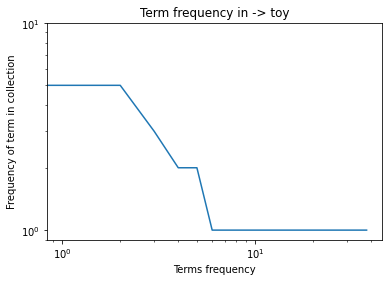

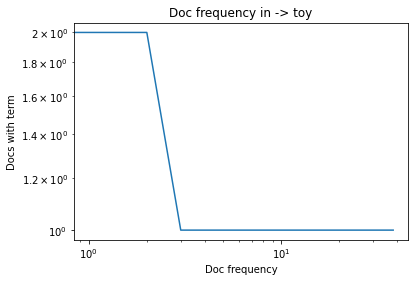

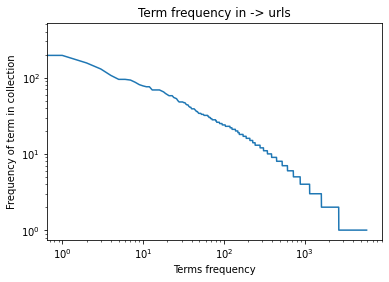

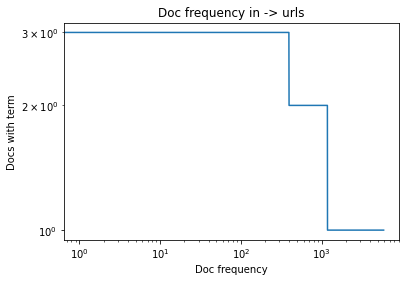

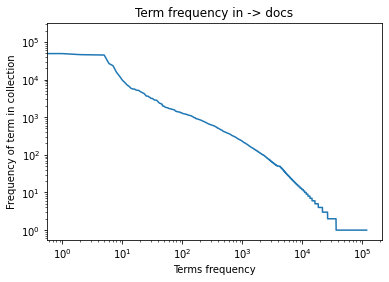

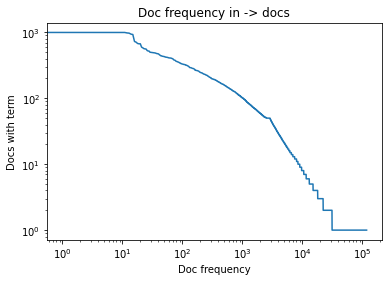

In [9]:
import os
import shutil
import time
#from statics import terms_stats
#from searcher import VSMDotProductSearcher, VSMCosineSearcher
#from whooshmethods import WhooshBuilder, WhooshIndex, WhooshSearcher


def main():
    index_root_dir = "./index/"
    collections_root_dir = "./collections/"
    test_collection (collections_root_dir + "toy/", index_root_dir + "toy", "cc", "aa dd")
    test_collection (collections_root_dir + "urls.txt", index_root_dir + "urls", "wikipedia", "information probability")
    test_collection (collections_root_dir + "docs1k.zip", index_root_dir + "docs", "seat", "obama family tree")

def clear (index_path: str):
    if os.path.exists(index_path): shutil.rmtree(index_path)
    else: print("Creating " + index_path)
    os.makedirs(index_path)

def test_collection(collection_path: str, index_path: str, word: str, query: str):
    start_time = time.time()
    print("=================================================================")
    print("Testing indices and search on " + collection_path)

    # Let's create the folder if it did not exist
    # and delete the index if it did
    clear(index_path)

    # We now test building an index
    test_build(WhooshBuilder(index_path), collection_path)

    # We now inspect the index
    index = WhooshIndex(index_path)
    test_read(index, word)
    term_stats(index) # comando para sacar las graficas

    print("------------------------------")
    print("Checking search results")
    test_search(WhooshSearcher(index_path), query, 5)
    test_search(VSMDotProductSearcher(WhooshIndex(index_path)), query, 5)
    test_search(VSMCosineSearcher(WhooshIndex(index_path)), query, 5)

def test_build(builder, collection):
    stamp = time.time()
    print("Building index with", type(builder))
    print("Collection:", collection)
    # this function should index the recieved collection and add it to the index
    builder.build(collection)
    # when we commit, the information in the index becomes persistent
    # we can also save any extra information we may need
    # (and that cannot be computed until the entire collection is scanned/indexed)
    builder.commit()
    print("Done (", time.time() - stamp, "seconds )")
    print()

def test_read(index, word):
    stamp = time.time()
    print("Reading index with", type(index))
    print("Collection size:", index.ndocs())
    print("Vocabulary size:", len(index.all_terms()))
    terms = index.all_terms_with_freq()
    terms.sort(key=lambda tup: tup[1], reverse=True)
    print("  Top 5 most frequent terms:")
    for term in terms[0:5]:
        print("\t" + term[0] + "\t" + str(term[1]) + "=" + str(index.total_freq(term)))
    print()
    # more tests
    doc_id = 0
    print()
    print("  Frequency of word \"" + word + "\" in document " + str(doc_id) + " - " + index.doc_path(doc_id) + ": " + str(index.term_freq(word, doc_id)))
    print("  Total frequency of word \"" + word + "\" in the collection: " + str(index.total_freq(word)) + " occurrences over " + str(index.doc_freq(word)) + " documents")
    print("  Docs containing the word'" + word + "':", index.doc_freq(word))
    print("Done (", time.time() - stamp, "seconds )")
    print()


def test_search (engine, query, cutoff):
    stamp = time.time()
    print("  " + engine.__class__.__name__ + " for query '" + query + "'")
    for path, score in engine.search(query, cutoff):
        print(score, "\t", path)
    print()
    print("Done (", time.time() - stamp, "seconds )")
    print()

main()

### Salida obtenida por el estudiante


In [ ]:
=================================================================
Testing indices and search on ./collections/toy/
Building index with <class 'whooshmethods.WhooshBuilder'>
Collection: ./collections/toy/
Done ( 0.16936922073364258 seconds )

Reading index with <class 'whooshmethods.WhooshIndex'>
Collection size: 4
Vocabulary size: 39
  Top 5 most frequent terms:
        aa      9.0=9.0
        bb      5.0=5.0
        sleep   5.0=5.0
        cc      3.0=3.0
        die     2.0=2.0


  Frequency of word "cc" in document 0 - ./collections/toy/d1.txt: 2
  Total frequency of word "cc" in the collection: 3.0 occurrences over 2 documents
  Docs containing the word'cc': 2
Done ( 0.0026397705078125 seconds )

------------------------------
Checking search results
  WhooshSearcher for query 'aa dd'

Done ( 0.021887540817260742 seconds )

  VSMDotProductSearcher for query 'aa dd'
4.0      ./collections/toy/d1.txt
1.7369655941662063       ./collections/toy/d2.txt
1.0      ./collections/toy/d3.txt

Done ( 0.0007722377777099609 seconds )

  VSMCosineSearcher for query 'aa dd'
1.0      ./collections/toy/d2.txt
0.7427813527082074       ./collections/toy/d1.txt
0.5773502691896258       ./collections/toy/d3.txt

Done ( 0.0008780956268310547 seconds )

=================================================================
Testing indices and search on ./collections/urls.txt
Building index with <class 'whooshmethods.WhooshBuilder'>
Collection: ./collections/urls.txt
Done ( 6.683624267578125 seconds )

Reading index with <class 'whooshmethods.WhooshIndex'>
Collection size: 3
Vocabulary size: 5873
  Top 5 most frequent terms:
        entropy 392.0=392.0
        bias    196.0=196.0
        system  156.0=156.0
        displaystyle    130.0=130.0
        edit    107.0=107.0


  Frequency of word "wikipedia" in document 0 - https://en.wikipedia.org/wiki/Simpson's_paradox
: 5
  Total frequency of word "wikipedia" in the collection: 21.0 occurrences over 3 documents
  Docs containing the word'wikipedia': 3
Done ( 0.0902857780456543 seconds )

------------------------------
Checking search results
  WhooshSearcher for query 'information probability'
2.9275452380913167       https://en.wikipedia.org/wiki/Entropy
2.475988540984066        https://en.wikipedia.org/wiki/Simpson's_paradox

2.084641587814708        https://en.wikipedia.org/wiki/Bias


Done ( 0.02002573013305664 seconds )

  VSMDotProductSearcher for query 'information probability'
2.201213664260036        https://en.wikipedia.org/wiki/Entropy
1.155870467654375        https://en.wikipedia.org/wiki/Bias

1.0252432526434019       https://en.wikipedia.org/wiki/Simpson's_paradox


Done ( 0.0023403167724609375 seconds )

  VSMCosineSearcher for query 'information probability'
0.021229211008499366     https://en.wikipedia.org/wiki/Simpson's_paradox

0.017476582465596094     https://en.wikipedia.org/wiki/Entropy
0.00952397401539877      https://en.wikipedia.org/wiki/Bias


Done ( 0.002106904983520508 seconds )

=================================================================
Testing indices and search on ./collections/docs1k.zip
Building index with <class 'whooshmethods.WhooshBuilder'>
Collection: ./collections/docs1k.zip
Done ( 57.39169192314148 seconds )

Reading index with <class 'whooshmethods.WhooshIndex'>
Collection size: 998
Vocabulary size: 118022
  Top 5 most frequent terms:
        family  175766.0=175766.0
        tree    46705.0=46705.0
        history 45744.0=45744.0
        genealogy       45405.0=45405.0
        surname 44965.0=44965.0


  Frequency of word "seat" in document 0 - clueweb09-en0000-01-22977.html: 28
  Total frequency of word "seat" in the collection: 1392.0 occurrences over 119 documents
  Docs containing the word'seat': 119
Done ( 1.921018123626709 seconds )

------------------------------
Checking search results
  WhooshSearcher for query 'obama family tree'
16.510355036382904       clueweb09-en0010-79-2218.html
15.912263448137267       clueweb09-en0010-57-32937.html
15.833557824663444       clueweb09-en0001-02-21241.html
15.635409879945282       clueweb09-en0008-45-29117.html
15.578551656409365       clueweb09-enwp01-59-16163.html
15.578551656409365       clueweb09-enwp02-06-15081.html

Done ( 0.10114669799804688 seconds )

  VSMDotProductSearcher for query 'obama family tree'
49.73029577380436        clueweb09-enwp01-59-16163.html
49.73029577380436        clueweb09-enwp02-06-15081.html
49.71745330976961        clueweb09-enwp03-00-6901.html
49.71745330976961        clueweb09-enwp03-07-2998.html
49.69823464015178        clueweb09-enwp00-00-9498.html

Done ( 0.8824598789215088 seconds )

  VSMCosineSearcher for query 'obama family tree'
0.28480133969659016      clueweb09-en0010-79-2218.html
0.22630799249136074      clueweb09-en0009-30-2768.html
0.22535524448825275      clueweb09-en0001-02-21241.html
0.22386434086185886      clueweb09-en0009-30-2441.html
0.2234923487378765       clueweb09-en0009-30-2755.html

Done ( 0.8222432136535645 seconds )